
# Supresvised Learning. Classification and Segmentation

---

**TODO:** Саликиев Денис 340290

---



Topics: pytorch, data preparation, data augmentation, custom model, transfer learning, classification, segmentation

Основные задачи

1. Решить проблему **классификации** дорожных фотографий
  1. Подготовьте данные и решите проблему несбалансированного набора данных
  2. Реализуйте и обучите пользовательский классификатор
  3. Реализуйте конвейер проверки
  4. Добавьте дополнения к данным и сравните результаты
  5. Загрузка предварительно обученной модели и настройка для фотографий дорог
2. Решите задачу **сегментации** дорожных фотографий (шаблон для этих задач будет выслан позже)
  1. Подготовьте данные
  2. Реализуйте (самостоятельно) SegNet или U-сеть и обучите ее
  3. Реализовать конвейер проверки

Подзадачи уточняются ниже.

Вопросы по лабораторной можно задать в телеграмме [@vedyakov](https://t.me/vedyakov).

**Требования**.

1. Вы выполнили лабораторную работу самостоятельно.
2. Выполнены все задачи и подзадачи. Выводы обоснованы и верны.
3. Код выполним, а результаты воспроизводимы. Если данные взяты из личного Google Drive, необходимо указать ссылку на них.
4. Тетрадь Colab должна содержать результаты выполнения кода в выводе ячейки.
5. Основная структура Colab Notebook сохраняется. Вы можете добавлять разделы, писать дополнительные функции и существенно не изменять разделы. Если вы удаляете текст и прочее, убедитесь, что все результаты выполнения задачи остаются явно выделенными.
6. Чтобы сдать лабораторную, необходимо отправить ссылку на общий доступ к Colab Notebook через [Google Form](https://forms.gle/AFpnYMKw4kKb1rUF7).

Если вы хотите продолжить работу, сделайте копию блокнота. Крайняя дата будет сопоставлена с последней модификацией

**Дедлайны для классификации (RU)**
- Мягкий – 24.03 23:59:59
- Жесткий – 27.03 23:59:59

----

Main Tasks
1. Solve the road photo **classification** problem
  1. Prepare data and solve imbalanced dataset problem
  2. Implement and train a custom classifier
  3. Implement validation pipeline
  4. Add data augmentation and compare results
  5. Load pre-trained model and tune for road photos
2. Solve the road photo **segmentation** problem (the template for these tasks will be sent later)
  1. Prepare data
  2. Implement (by yourself) SegNet or U-net and train it
  3. Implement validation pipeline
  
Subtasks are specified in-place.

You can ask question about lab in the telegram [@vedyakov](https://t.me/vedyakov).

**Requirements**
1. You did the lab on your own.
2. All tasks and subtasks are completed. Conclusions are well-founded and valid.
3. The code is executable and the results are reproducible. If data is taken from your personal Google Drive, a link to the data should be provided.
4. The Colab notebook must contain the results of the code execution in the cell output.
5. The main structure of this Colab Notebook is preserved. You can add sections, write additional functions, and not significatly change the sections. If you remove any text and other things, make sure that all task results remain explicitly marked.
6. To pass the lab you should send the sharing link to your Colab Notebook via [Google Form](https://forms.gle/AFpnYMKw4kKb1rUF7).
If you want continue your work, make a copy of the notebook. The deadline date will be comparing with the last modification date of your notebook (you should not modify the notebook after you submit it).

**Deadlines for classification (RU)**
- Soft – 24.03 23:59:59
- Hard – 27.03 23:59:59



 ## Enviroment setup

Import packages

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from torchvision import models, transforms

import time
import math
import random

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import colors, pyplot as plt
from matplotlib import rcParams
from IPython.display import clear_output

from tqdm import tqdm

%matplotlib inline
rcParams['figure.figsize'] = (15,4)
sns.set(style="darkgrid", font_scale=1.4)

Define the device variable to run notebook on gpu if it is available and cpu in the opposite case without any notebook modifications

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU = torch.device('cuda:0')
CPU = torch.device('cpu')

Specify a seed to more reproducable results. Now the mentioned below random generators will produce the same random sequencies.

In [ ]:
SEED = 42 # You can set any interger here

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

Here some snippets to check GPU params

In [ ]:
!nvidia-smi
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

Thu Mar 20 18:23:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

The snippet below can be used to check GPU memory allocation and clean it

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Dataset loading

### Way 1. By direct link

Используйте одну из ссылок / Use one of the links below
- https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
- http://mlr.vedyakov.com/segmentation_new.zip

In [ ]:
!wget -c http://mlr.vedyakov.com/segmentation_new.zip -O segmentation.zip

--2025-03-17 17:41:42--  http://mlr.vedyakov.com/segmentation_new.zip
Resolving mlr.vedyakov.com (mlr.vedyakov.com)... 77.234.215.110
Connecting to mlr.vedyakov.com (mlr.vedyakov.com)|77.234.215.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418673165 (399M) [application/zip]
Saving to: ‘segmentation.zip’

segmentation.zip    100%[===================>] 399.28M  7.35MB/s    in 66s     

2025-03-17 17:42:49 (6.04 MB/s) - ‘segmentation.zip’ saved [418673165/418673165]



Then we should unzip

In [ ]:
!unzip -q ./segmentation.zip

### Way 2. From personal Google drive

Add file to your personal google drive https://drive.google.com/file/d/1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL/view?usp=sharing or download from cloud services (Here are a few links since they stop working periodically)
- https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
- https://niuitmo-my.sharepoint.com/:u:/g/personal/vedyakov_niuitmo_ru/Ec4GW6NfTaJOhdUgfHwwTpQB09j7apoB9pJ3tq7sIWLwsg?e=iADkMZ
- https://disk.yandex.ru/d/azhOrDCv1P3rDw
and upload to the personal google drive. In the example, the file in the University/MLR directory.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/MyDrive/University/MLR

In [ ]:
!unzip -q /content/gdrive/MyDrive/datasets_for_colab/segmentation.zip

## Data preparation

### Data checking

In [ ]:
X = np.load('./x_train.npy')
Y = np.load('./y_train.npy')

print(X.shape)
print(Y.shape)
print(Y[0])

(3083, 256, 256, 3)
(3083, 256, 256, 1)
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


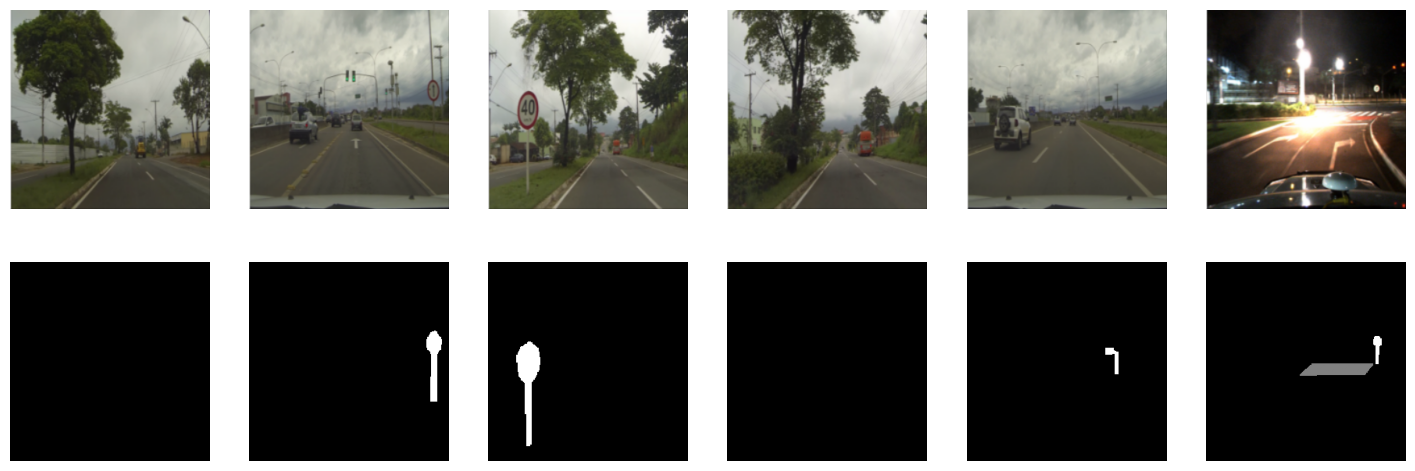

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 100+10*i;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

### Preparing target values for the classification task

Let us find all possible Y values in the dataset

In [ ]:
unique, counts = np.unique(Y, return_counts=True)

result = np.column_stack((unique, counts))
print(result)

[[        0 192720674]
 [        1   8499283]
 [        2    827531]]


If number of non-black pixels is less than threshold, then we say that there is not a road sign on the photo

In [ ]:
sum_by_image = np.sum(Y, (1, 2, 3))
print(sum_by_image.shape)

(3083,)


In [ ]:
unique, counts = np.unique(sum_by_image, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

[[    0   461]
 [    8     1]
 [   32     1]
 ...
 [29420     1]
 [29790     1]
 [33807     1]]


In [ ]:
print(np.max(result))

33807


In [ ]:
threshold = 50# TODO: Define threshold for the number of non-black pixels
Y_c = np.array(sum_by_image > threshold, dtype='uint8')
print(Y_c.shape)

(3083,)


Now we have labels for classification task

In [ ]:
print(Y_c[0:100])

[0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0]


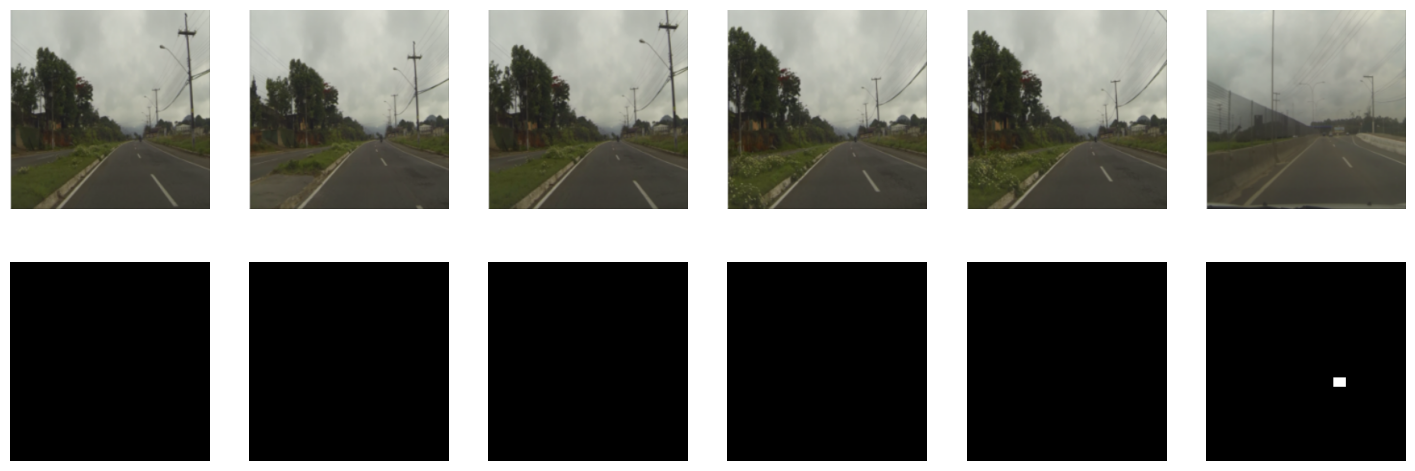

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 2 + i;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

### Data normalization

For pytorch, the channel should be the second dimension, not the last one.

In [ ]:
X_r = np.transpose(X, axes=(0, 3, 1, 2))
Y_r = Y_c
print(X_r.shape, Y_r.shape)

(3083, 3, 256, 256) (3083,)


Normalize data and convert to tensors

In [ ]:
X_f = np.array(X_r / 255, dtype='float32')# TODO: convert 0-255 values to 0-1
X_t = torch.FloatTensor(X_f)

for x in X_t:
  transforms.functional.normalize(x, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True)

Y_t = torch.FloatTensor(Y_r)

Splitting dataset

Let us divide for traning, validation and test correspondingly.

In [ ]:
ix = np.random.choice(len(X_t), len(X_t), False)
val_index = 2800# TODO: set the index where dataset will be splitted between train and validation
test_index = 3000# TODO: set the index where dataset will be splitted between validation and test
tr, val, ts = np.split(ix, [val_index, test_index])

In [ ]:
X_train_t = X_t[tr]
X_val_t = X_t[val]
X_test_t = X_t[ts]

Y_train_t = Y_t[tr]
Y_val_t = Y_t[val]
Y_test_t = Y_t[ts]

train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset = TensorDataset(X_val_t, Y_val_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

In [ ]:
unique, counts = np.unique(Y_train_t, return_counts=True)
result = np.column_stack((unique, counts))
print (result)

[[0.000e+00 4.270e+02]
 [1.000e+00 2.373e+03]]


Check converted and normalized data

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
      if hasattr(plt_ax, 'set_title'):
        plt_ax.set_title(title)
      if hasattr(plt_ax, 'title'):
        plt_ax.title(title)
    plt_ax.grid(False)

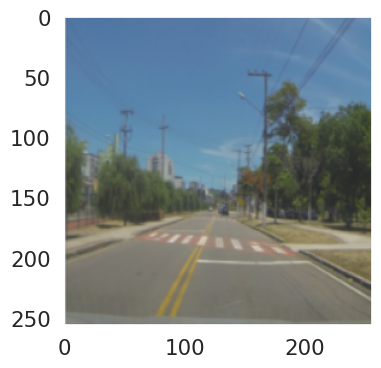

In [ ]:
imshow(X_train_t[0])

### Classes balancing and creating dataloaders

Let's count how many pictures we have for each class.

In [ ]:
unique, counts = np.unique(Y_r, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

[[   0  465]
 [   1 2618]]


The dataset is not balanced, so let's define the weights for each class.

In order for the classes to be balanced in training, we calculate the weights and create a sampler.
For the validation and test, we will not use balancing.

In [ ]:
unique, counts = np.unique(Y_r[tr], return_counts=True)
w = np.min(counts)/counts
print(w)

[1.       0.179941]


In [ ]:
weights = [w[0] if x == 0 else w[1] for x in Y_r[tr]]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))# TODO: create WeightedRandomSampler instance, see https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler

print(Y_r[tr][50:100:5])
print(weights[50:100:5])

[1 1 1 1 1 1 0 1 0 1]
[np.float64(0.17994100294985252), np.float64(0.17994100294985252), np.float64(0.17994100294985252), np.float64(0.17994100294985252), np.float64(0.17994100294985252), np.float64(0.17994100294985252), np.float64(1.0), np.float64(0.17994100294985252), np.float64(1.0), np.float64(0.17994100294985252)]


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Let's check that the classes are balanced now

In [ ]:
YY_check = np.array([])

for _, y in train_dataloader:
  YY_check = np.hstack((YY_check, y.detach().numpy()))

unique, counts = np.unique(YY_check, return_counts=True)
result = np.column_stack((unique, counts))
print(result)

[[0.000e+00 1.409e+03]
 [1.000e+00 1.391e+03]]


Taking into account the imbalance of classes in the validation and test samples, we will use a special metric to evaluate the quality of training.

In [ ]:
from sklearn.metrics import balanced_accuracy_score

## Custom classifier and training

**Pass requirement**: balanced_accuracy_score metric on the test part of the dataset is at least **0.95**.

In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, size, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        ) # => 128x8
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        ) # => 64x16
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        ) # => 32x32
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        ) # => 16x64

        fc_inputs = int((size/16)*(size/16)*64)

        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_inputs, 96 * 5),
            nn.ReLU(),
            nn.BatchNorm1d(96 * 5),
            nn.Dropout(p=0.2),
            nn.Linear(96 * 5, 96 * 4),
            nn.ReLU(),
            nn.BatchNorm1d(96 * 4),
            nn.Dropout(p=0.1),
            nn.Linear(96 * 4, n_classes)# TODO: Add last linear layer
        )


    def forward(self, x):
        # TODO: pass x to sequentially to all conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)

        return logits.squeeze()

Let us define training function

In [ ]:
from tqdm import tqdm

In [ ]:
def train(model, optimizer, loss_function, dataloader, max_epochs = 10):
  losses = np.zeros(max_epochs)

  model.train()
  for epoch in tqdm(range(max_epochs)):
      for it, (X_batch, y_batch) in enumerate(dataloader):
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)

          optimizer.zero_grad()

          outp = model(X_batch)# TODO: predict y with model using X_batch

          loss = loss_function(outp.squeeze(), y_batch)
          losses[epoch] = losses[epoch] + loss.detach().flatten()[0]

          loss.backward() # TODO: call back propagation and gradient calculation
          optimizer.step() # TODO: call weights update

          y_batch = y_batch.cpu()
          X_batch = X_batch.cpu()
          outp = outp.cpu()

      print(f"Epoch {epoch}: loss={losses[epoch]}")

  return losses

Now we can create model, define loss function and optimizer

In [ ]:
simpleNN = SimpleCnn(256, 1).to(device=device)# TODO: create model and move it to device
loss_function = torch.nn.BCEWithLogitsLoss()# TODO: create loss function
learning_rate = 0.0001# TODO: set learning rate
optimizer = torch.optim.Adam(simpleNN.parameters(), lr=learning_rate)

and train our model

In [ ]:
max_epochs = 40# TODO: set max epochs number
losses = train(simpleNN, optimizer, loss_function, train_dataloader, max_epochs)

  2%|▎         | 1/40 [00:06<03:57,  6.09s/it]

Epoch 0: loss=6.388423442840576


  5%|▌         | 2/40 [00:12<03:57,  6.26s/it]

Epoch 1: loss=2.3601434230804443


  8%|▊         | 3/40 [00:18<03:48,  6.17s/it]

Epoch 2: loss=1.4163190126419067


 10%|█         | 4/40 [00:24<03:45,  6.26s/it]

Epoch 3: loss=0.7828476428985596


 12%|█▎        | 5/40 [00:30<03:36,  6.17s/it]

Epoch 4: loss=0.5701449513435364


 15%|█▌        | 6/40 [00:37<03:32,  6.26s/it]

Epoch 5: loss=0.3517855405807495


 18%|█▊        | 7/40 [00:43<03:24,  6.19s/it]

Epoch 6: loss=0.2831127345561981


 20%|██        | 8/40 [00:49<03:20,  6.26s/it]

Epoch 7: loss=0.1961784064769745


 22%|██▎       | 9/40 [00:55<03:11,  6.19s/it]

Epoch 8: loss=0.13195139169692993


 25%|██▌       | 10/40 [01:02<03:07,  6.25s/it]

Epoch 9: loss=0.18060560524463654


 28%|██▊       | 11/40 [01:08<02:59,  6.21s/it]

Epoch 10: loss=0.17683345079421997


 30%|███       | 12/40 [01:14<02:54,  6.24s/it]

Epoch 11: loss=0.10596378892660141


 32%|███▎      | 13/40 [01:20<02:47,  6.22s/it]

Epoch 12: loss=0.09951476007699966


 35%|███▌      | 14/40 [01:27<02:41,  6.21s/it]

Epoch 13: loss=0.11012633144855499


 38%|███▊      | 15/40 [01:33<02:35,  6.22s/it]

Epoch 14: loss=0.06811609119176865


 40%|████      | 16/40 [01:39<02:28,  6.20s/it]

Epoch 15: loss=0.06979416310787201


 42%|████▎     | 17/40 [01:45<02:23,  6.23s/it]

Epoch 16: loss=0.07510805130004883


 45%|████▌     | 18/40 [01:51<02:16,  6.19s/it]

Epoch 17: loss=0.14560829102993011


 48%|████▊     | 19/40 [01:58<02:11,  6.26s/it]

Epoch 18: loss=0.08011384308338165


 50%|█████     | 20/40 [02:04<02:04,  6.21s/it]

Epoch 19: loss=0.04236661270260811


 52%|█████▎    | 21/40 [02:10<01:59,  6.26s/it]

Epoch 20: loss=0.04931257292628288


 55%|█████▌    | 22/40 [02:16<01:51,  6.20s/it]

Epoch 21: loss=0.06332682073116302


 57%|█████▊    | 23/40 [02:23<01:46,  6.25s/it]

Epoch 22: loss=0.12795567512512207


 60%|██████    | 24/40 [02:29<01:38,  6.18s/it]

Epoch 23: loss=0.13642163574695587


 62%|██████▎   | 25/40 [02:35<01:33,  6.25s/it]

Epoch 24: loss=0.020291626453399658


 65%|██████▌   | 26/40 [02:41<01:26,  6.19s/it]

Epoch 25: loss=0.03137976676225662


 68%|██████▊   | 27/40 [02:48<01:21,  6.26s/it]

Epoch 26: loss=0.07137414067983627


 70%|███████   | 28/40 [02:54<01:14,  6.19s/it]

Epoch 27: loss=0.029943175613880157


 72%|███████▎  | 29/40 [03:00<01:08,  6.25s/it]

Epoch 28: loss=0.016754046082496643


 75%|███████▌  | 30/40 [03:06<01:01,  6.19s/it]

Epoch 29: loss=0.0573124885559082


 78%|███████▊  | 31/40 [03:12<00:56,  6.25s/it]

Epoch 30: loss=0.014661950059235096


 80%|████████  | 32/40 [03:18<00:49,  6.19s/it]

Epoch 31: loss=0.017093932256102562


 82%|████████▎ | 33/40 [03:25<00:43,  6.25s/it]

Epoch 32: loss=0.00998507346957922


 85%|████████▌ | 34/40 [03:31<00:38,  6.36s/it]

Epoch 33: loss=0.04970374330878258


 88%|████████▊ | 35/40 [03:41<00:35,  7.19s/it]

Epoch 34: loss=0.01384795643389225


 90%|█████████ | 36/40 [03:47<00:28,  7.04s/it]

Epoch 35: loss=0.04966294392943382


 92%|█████████▎| 37/40 [03:53<00:20,  6.72s/it]

Epoch 36: loss=0.01170894131064415


 95%|█████████▌| 38/40 [04:00<00:13,  6.60s/it]

Epoch 37: loss=0.009487232193350792


 98%|█████████▊| 39/40 [04:06<00:06,  6.41s/it]

Epoch 38: loss=0.033149510622024536


100%|██████████| 40/40 [04:12<00:00,  6.31s/it]

Epoch 39: loss=0.017512040212750435


In [ ]:
def plot_losses(losses):
  plt.figure(figsize=(12, 8))
  plt.plot(range(len(losses)), losses)
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

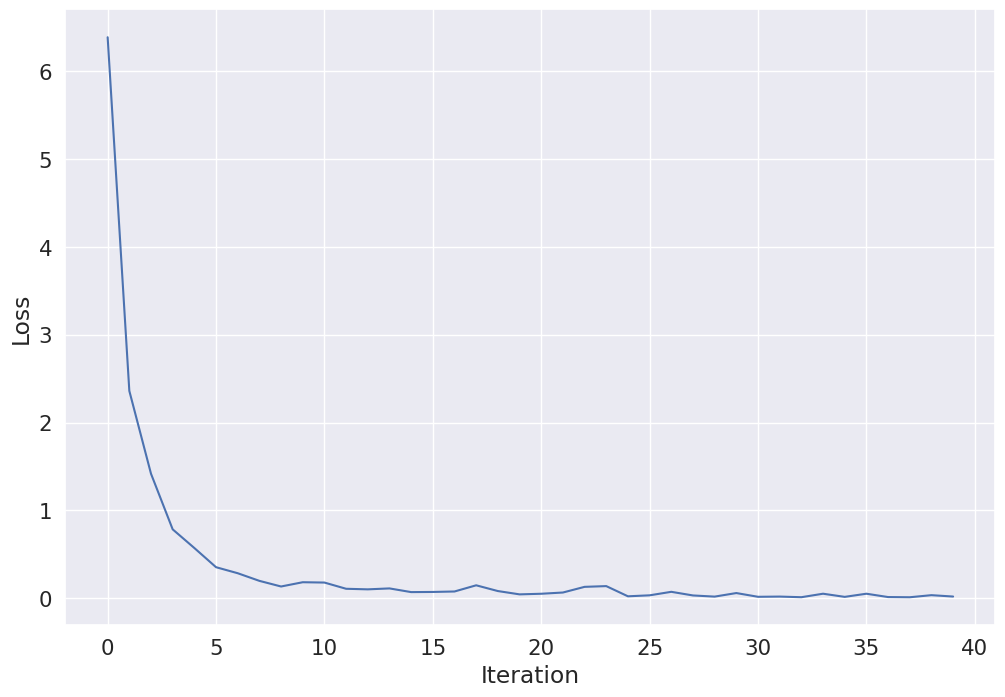

In [ ]:
plot_losses(losses)

We can additionally train the model with the lowel learning rate. However, the better idea is to use [schedulers](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling), so we suggest to try it.

In [ ]:
# [OPTIONAL] TODO: try to use learning rate scheduler

## Model validation

In order to check overfitting we compate metric results on the train and validation datasets. If everything is ok, then we check on test dataset.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    y_target = np.array([])
    for x_batch, y_batch in dataloader:
        y_target = np.hstack((y_target, y_batch.numpy().flatten()))
        x_batch = x_batch.to(device)
        lgts = model(x_batch)
        probs = torch.sigmoid(lgts)
        preds = (probs > 0.5).type(torch.long).cpu()
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        x_batch = x_batch.cpu()
    model.train()
    # We return also target for the cases, when data is shuffled
    return predictions.flatten(), y_target

In [ ]:
Y_pred_train, Y_target_train = predict(train_dataloader, simpleNN)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_target_train, Y_pred_train)

np.float64(1.0)

In [ ]:
Y_pred_val, Y_target_val = predict(val_dataloader, simpleNN)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_target_val, Y_pred_val)

np.float64(0.9734848484848485)

In [ ]:
Y_test_pred, Y_test_target = predict(test_dataloader, simpleNN)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_test_target, Y_test_pred)

np.float64(0.9213250517598344)

**TODO:** write a conclusion about obtained results

**Pass requirement:** balanced_accuracy_score metric on the val part of the dataset is at least 0.85. If accuracy is less than 0.85, then add the code below and fix it. If it is greater than 0.85 you can move to the next section.

## Data Augmentation

In the common case the best way to increase size of the dataset is using on-fly data augmentation. In this case each time when we get item from the dataset transformation with random parameters is applied. However, the transformations must give you realistic images that are similar to the original images.

For the on-fly transformations we will create custom class dataset

In [ ]:
class OurOwnDataset(Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms

        print(f'Found {len(self.data)} items')

    def __getitem__(self, i):
        image = self.data[i]

        if self.transforms:
            image = self.transforms(image)

        label = self.labels[i]

        return image, label

    def __len__(self):
        return len(self.df)

In [ ]:
from torchvision.transforms import Compose # TODO: add transforms import, see https://pytorch.org/vision/stable/transforms.html
from torchvision.transforms import v2

getitem_transforms = Compose([
    v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.2),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset_augmented = OurOwnDataset(X_train_t, Y_train_t, transforms=getitem_transforms)

Found 2800 items


Check how it is working

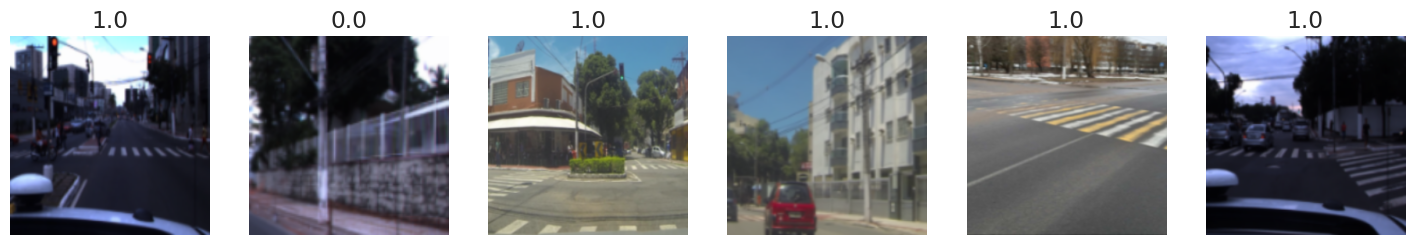

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 100+10*i;
    image, label = train_dataset_augmented.__getitem__(j)

    plt.subplot(2, 6, i+1)
    plt.axis("off")

    imshow(image, title=f'{label}', plt_ax=plt)
plt.show();

In [ ]:
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=128, sampler=sampler)

Now we can create new model and train it

In [ ]:
model2 = SimpleCnn(256, 1).to(device=device)# TODO: create a new model with SimpleCnn class and move it to device
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)
loss_function2 = torch.nn.BCEWithLogitsLoss()# TODO: create loss function

learning_rate2 = 0.0001# TODO: set learning rate

optimizer3 = torch.optim.Adam(model2.parameters(), lr=learning_rate2)
max_epochs2 = 30

In [ ]:
losses2 = train(model2, optimizer2, loss_function2, train_dataloader_augmented, max_epochs2)# TODO: call train function and pass train_dataloader_augmented as dataloader

  3%|▎         | 1/30 [00:09<04:36,  9.54s/it]

Epoch 0: loss=11.553930282592773


  7%|▋         | 2/30 [00:18<04:23,  9.41s/it]

Epoch 1: loss=9.371719360351562


 10%|█         | 3/30 [00:27<04:07,  9.18s/it]

Epoch 2: loss=8.835112571716309


 13%|█▎        | 4/30 [00:37<04:01,  9.29s/it]

Epoch 3: loss=8.234837532043457


 17%|█▋        | 5/30 [00:46<03:54,  9.36s/it]

Epoch 4: loss=7.927801609039307


 20%|██        | 6/30 [00:56<03:44,  9.37s/it]

Epoch 5: loss=7.562395095825195


 23%|██▎       | 7/30 [01:05<03:32,  9.23s/it]

Epoch 6: loss=7.581454277038574


 27%|██▋       | 8/30 [01:14<03:25,  9.33s/it]

Epoch 7: loss=7.2513580322265625


 30%|███       | 9/30 [01:24<03:16,  9.37s/it]

Epoch 8: loss=7.088556289672852


 33%|███▎      | 10/30 [01:33<03:07,  9.39s/it]

Epoch 9: loss=6.90566349029541


 37%|███▋      | 11/30 [01:42<02:57,  9.33s/it]

Epoch 10: loss=6.801217555999756


 40%|████      | 12/30 [01:51<02:46,  9.27s/it]

Epoch 11: loss=6.6187825202941895


 43%|████▎     | 13/30 [02:01<02:38,  9.31s/it]

Epoch 12: loss=6.296591281890869


 47%|████▋     | 14/30 [02:10<02:29,  9.36s/it]

Epoch 13: loss=5.829551696777344


 50%|█████     | 15/30 [02:20<02:21,  9.40s/it]

Epoch 14: loss=6.36886739730835


 53%|█████▎    | 16/30 [02:28<02:09,  9.22s/it]

Epoch 15: loss=6.354191303253174


 57%|█████▋    | 17/30 [02:38<02:02,  9.41s/it]

Epoch 16: loss=6.033956527709961


 60%|██████    | 18/30 [02:52<02:08, 10.74s/it]

Epoch 17: loss=6.04388427734375


 63%|██████▎   | 19/30 [03:05<02:06, 11.50s/it]

Epoch 18: loss=5.848571300506592


 67%|██████▋   | 20/30 [03:18<01:57, 11.71s/it]

Epoch 19: loss=5.959807872772217


 70%|███████   | 21/30 [03:30<01:45, 11.76s/it]

Epoch 20: loss=5.508216857910156


 73%|███████▎  | 22/30 [03:41<01:34, 11.82s/it]

Epoch 21: loss=5.638025283813477


 77%|███████▋  | 23/30 [03:51<01:17, 11.09s/it]

Epoch 22: loss=5.596347332000732


 80%|████████  | 24/30 [04:01<01:05, 10.93s/it]

Epoch 23: loss=5.419707298278809


 83%|████████▎ | 25/30 [04:11<00:52, 10.51s/it]

Epoch 24: loss=5.295417785644531


 87%|████████▋ | 26/30 [04:20<00:40, 10.01s/it]

Epoch 25: loss=5.384861946105957


 90%|█████████ | 27/30 [04:29<00:29,  9.78s/it]

Epoch 26: loss=5.097598552703857


 93%|█████████▎| 28/30 [04:38<00:19,  9.67s/it]

Epoch 27: loss=5.201145172119141


 97%|█████████▋| 29/30 [04:48<00:09,  9.69s/it]

Epoch 28: loss=4.9781413078308105


100%|██████████| 30/30 [04:57<00:00,  9.93s/it]

Epoch 29: loss=5.377449035644531


Check accuracy

In [ ]:
Y_train_pred2, Y_train_target2 = predict(train_dataloader_augmented, model2)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_train_target2, Y_train_pred2)

np.float64(0.8844941714854905)

**Pass requirement**: balanced_accuracy_score metric on the val part of the dataset is at least 0.96.

In [ ]:
Y_pred_val2, Y_target_val2 = predict(val_dataloader, model2)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_target_val2, Y_pred_val2)

np.float64(0.956439393939394)

In [ ]:
Y_pred_val2, Y_target_val2 = predict(val_dataloader, model2)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_target_val2, Y_pred_val2)

np.float64(0.9479166666666667)

In [ ]:
optimizer3 = torch.optim.Adam(model2.parameters(), lr=1e-5)
max_epochs2 = 30

losses3 = train(model2, optimizer2, loss_function2, train_dataloader_augmented, max_epochs2)

  3%|▎         | 1/30 [00:09<04:38,  9.60s/it]

Epoch 0: loss=5.026520729064941


  7%|▋         | 2/30 [00:18<04:23,  9.40s/it]

Epoch 1: loss=4.908923625946045


 10%|█         | 3/30 [00:28<04:20,  9.66s/it]

Epoch 2: loss=5.004229545593262


 13%|█▎        | 4/30 [00:38<04:12,  9.72s/it]

Epoch 3: loss=4.542694568634033


 17%|█▋        | 5/30 [00:48<04:01,  9.64s/it]

Epoch 4: loss=4.968242168426514


 20%|██        | 6/30 [00:57<03:50,  9.62s/it]

Epoch 5: loss=4.664261817932129


 23%|██▎       | 7/30 [01:10<04:02, 10.53s/it]

Epoch 6: loss=4.706902503967285


 27%|██▋       | 8/30 [01:19<03:41, 10.05s/it]

Epoch 7: loss=4.6270623207092285


 30%|███       | 9/30 [01:28<03:25,  9.78s/it]

Epoch 8: loss=4.742562770843506


 33%|███▎      | 10/30 [01:37<03:13,  9.65s/it]

Epoch 9: loss=4.257974624633789


 37%|███▋      | 11/30 [01:47<03:02,  9.60s/it]

Epoch 10: loss=4.468395709991455


 40%|████      | 12/30 [01:56<02:51,  9.55s/it]

Epoch 11: loss=4.183845043182373


 43%|████▎     | 13/30 [02:05<02:40,  9.45s/it]

Epoch 12: loss=4.40175724029541


 47%|████▋     | 14/30 [02:15<02:33,  9.60s/it]

Epoch 13: loss=4.470330715179443


 50%|█████     | 15/30 [02:25<02:24,  9.66s/it]

Epoch 14: loss=4.701385974884033


 53%|█████▎    | 16/30 [02:35<02:15,  9.66s/it]

Epoch 15: loss=4.465877056121826


 57%|█████▋    | 17/30 [02:44<02:04,  9.56s/it]

Epoch 16: loss=4.97973108291626


 60%|██████    | 18/30 [02:53<01:53,  9.49s/it]

Epoch 17: loss=4.594707489013672


 63%|██████▎   | 19/30 [03:03<01:44,  9.53s/it]

Epoch 18: loss=4.304005146026611


 67%|██████▋   | 20/30 [03:12<01:35,  9.51s/it]

Epoch 19: loss=4.590203762054443


 70%|███████   | 21/30 [03:22<01:25,  9.50s/it]

Epoch 20: loss=4.171759128570557


 73%|███████▎  | 22/30 [03:31<01:14,  9.32s/it]

Epoch 21: loss=4.538502216339111


 77%|███████▋  | 23/30 [03:40<01:05,  9.37s/it]

Epoch 22: loss=4.153855323791504


 80%|████████  | 24/30 [03:50<00:56,  9.42s/it]

Epoch 23: loss=4.514101505279541


 83%|████████▎ | 25/30 [03:59<00:47,  9.48s/it]

Epoch 24: loss=4.081178665161133


 87%|████████▋ | 26/30 [04:09<00:37,  9.45s/it]

Epoch 25: loss=4.464702606201172


 90%|█████████ | 27/30 [04:18<00:28,  9.38s/it]

Epoch 26: loss=4.562952041625977


 93%|█████████▎| 28/30 [04:28<00:18,  9.42s/it]

Epoch 27: loss=4.26992130279541


 97%|█████████▋| 29/30 [04:37<00:09,  9.44s/it]

Epoch 28: loss=4.278378963470459


100%|██████████| 30/30 [04:47<00:00,  9.57s/it]

Epoch 29: loss=4.024421691894531


In [ ]:
Y_pred_val2, Y_target_val2 = predict(val_dataloader, model2)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_target_val2, Y_pred_val2)

np.float64(0.956439393939394)

In [ ]:
optimizer4 = torch.optim.Adam(model2.parameters(), lr=1e-6)
max_epochs2 = 30

losses3 = train(model2, optimizer4, loss_function2, train_dataloader_augmented, max_epochs2)

  3%|▎         | 1/30 [00:09<04:29,  9.29s/it]

Epoch 0: loss=4.136528015136719


  7%|▋         | 2/30 [00:18<04:19,  9.25s/it]

Epoch 1: loss=3.6496076583862305


 10%|█         | 3/30 [00:28<04:14,  9.42s/it]

Epoch 2: loss=4.00878381729126


 13%|█▎        | 4/30 [00:37<04:05,  9.44s/it]

Epoch 3: loss=3.8543944358825684


 17%|█▋        | 5/30 [00:47<03:56,  9.45s/it]

Epoch 4: loss=3.8575026988983154


 20%|██        | 6/30 [00:55<03:42,  9.26s/it]

Epoch 5: loss=4.1390380859375


 23%|██▎       | 7/30 [01:05<03:34,  9.31s/it]

Epoch 6: loss=4.070639133453369


 27%|██▋       | 8/30 [01:14<03:26,  9.38s/it]

Epoch 7: loss=3.7385261058807373


 30%|███       | 9/30 [01:24<03:17,  9.40s/it]

Epoch 8: loss=3.841399669647217


 33%|███▎      | 10/30 [01:33<03:06,  9.30s/it]

Epoch 9: loss=3.6018171310424805


 37%|███▋      | 11/30 [01:42<02:56,  9.29s/it]

Epoch 10: loss=3.784247636795044


 40%|████      | 12/30 [01:52<02:47,  9.32s/it]

Epoch 11: loss=3.6767735481262207


 43%|████▎     | 13/30 [02:01<02:39,  9.38s/it]

Epoch 12: loss=3.77504563331604


 47%|████▋     | 14/30 [02:10<02:30,  9.38s/it]

Epoch 13: loss=4.0907721519470215


 50%|█████     | 15/30 [02:20<02:19,  9.29s/it]

Epoch 14: loss=3.5043911933898926


 53%|█████▎    | 16/30 [02:29<02:11,  9.36s/it]

Epoch 15: loss=3.7634129524230957


 57%|█████▋    | 17/30 [02:39<02:02,  9.40s/it]

Epoch 16: loss=3.9493093490600586


 60%|██████    | 18/30 [02:48<01:53,  9.46s/it]

Epoch 17: loss=4.151618957519531


 63%|██████▎   | 19/30 [02:57<01:42,  9.31s/it]

Epoch 18: loss=3.8514411449432373


 67%|██████▋   | 20/30 [03:07<01:33,  9.38s/it]

Epoch 19: loss=3.865683078765869


 70%|███████   | 21/30 [03:16<01:25,  9.47s/it]

Epoch 20: loss=3.7785868644714355


 73%|███████▎  | 22/30 [03:26<01:15,  9.45s/it]

Epoch 21: loss=3.6057639122009277


 77%|███████▋  | 23/30 [03:35<01:05,  9.42s/it]

Epoch 22: loss=3.852918863296509


 80%|████████  | 24/30 [03:44<00:55,  9.30s/it]

Epoch 23: loss=3.827320098876953


 83%|████████▎ | 25/30 [03:54<00:46,  9.34s/it]

Epoch 24: loss=3.7211804389953613


 87%|████████▋ | 26/30 [04:03<00:37,  9.41s/it]

Epoch 25: loss=3.680176019668579


 90%|█████████ | 27/30 [04:13<00:28,  9.45s/it]

Epoch 26: loss=3.9736487865448


 93%|█████████▎| 28/30 [04:22<00:18,  9.28s/it]

Epoch 27: loss=4.1301164627075195


 97%|█████████▋| 29/30 [04:31<00:09,  9.34s/it]

Epoch 28: loss=3.7507452964782715


100%|██████████| 30/30 [04:41<00:00,  9.37s/it]

Epoch 29: loss=3.4203593730926514


In [ ]:
Y_pred_val2, Y_target_val2 = predict(val_dataloader, model2)
# TODO: calculate accuracy with balanced_accuracy_score function
balanced_accuracy_score(Y_target_val2, Y_pred_val2)

np.float64(0.9678030303030303)

## Transfer learning

The main idea is to load model and slightly tune it's parameters. The pre-trained models can be found in various libraries, for example in pytorch, or more specifically in [torchvision.models](https://pytorch.org/vision/stable/models.html#classification)

In [ ]:
from torchvision.io import decode_image
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model_resnet = resnet50(weights=weights) # create model, for torchvision.models it will looks like: models.some_model_name(pretrained=True)
print(model_resnet)

# model3.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


First of all we must change the number of the outputs. For example, the models trained on IMAGENET have 1000 outputs, but we need only 1 output.

We can replace the whole classifier block (which is placed after convolution layers) or the last layer of the classifier.

In [ ]:
# Disable gradient calculations for the pretrained model
# It will speed up the calculations and it is a way for freeze parameters values
for par in model_resnet.parameters():
  par.requires_grad = False

model_resnet.fc = nn.Linear(in_features=2048, out_features=1, bias=True) # TODO: Define a new classifier block for the model3

In [ ]:
model_resnet = model_resnet.to(device)
loss_func_resnet = torch.nn.BCEWithLogitsLoss()

 10%|█         | 1/10 [00:15<02:16, 15.22s/it]

Epoch 0: loss=12.299284934997559


 20%|██        | 2/10 [00:30<02:01, 15.14s/it]

Epoch 1: loss=4.535290718078613


 30%|███       | 3/10 [00:45<01:44, 14.99s/it]

Epoch 2: loss=2.6338613033294678


 40%|████      | 4/10 [00:59<01:29, 14.84s/it]

Epoch 3: loss=2.4600470066070557


 50%|█████     | 5/10 [01:14<01:13, 14.79s/it]

Epoch 4: loss=2.080559730529785


 60%|██████    | 6/10 [01:29<00:59, 14.78s/it]

Epoch 5: loss=1.0728836059570312


 70%|███████   | 7/10 [01:44<00:44, 14.80s/it]

Epoch 6: loss=0.9375292658805847


 80%|████████  | 8/10 [01:59<00:29, 14.85s/it]

Epoch 7: loss=0.8856213688850403


 90%|█████████ | 9/10 [02:13<00:14, 14.89s/it]

Epoch 8: loss=0.7782061100006104


100%|██████████| 10/10 [02:28<00:00, 14.87s/it]

Epoch 9: loss=0.5920068621635437


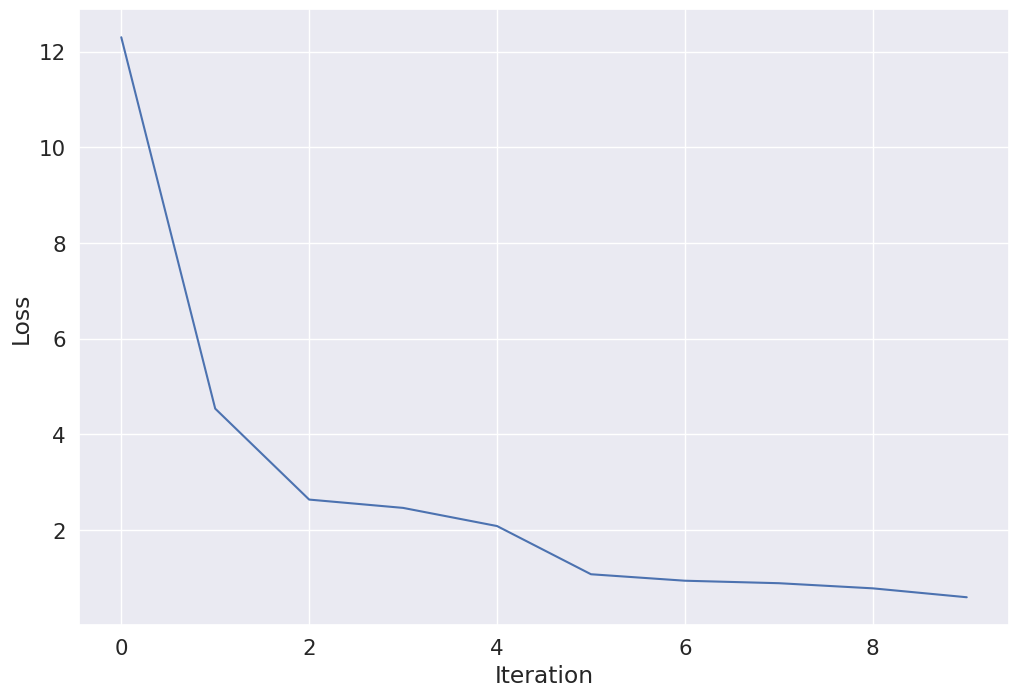

In [ ]:
# You can tune only classifier parameters by passing only that params to the optimizer
learning_rate_resnet=5e-2
max_epochs=10
optimizer_resnet = torch.optim.Adam(model_resnet.fc.parameters(), lr=learning_rate_resnet)# TODO: create optimizer and pass to it onl ymodel3.classifier parameters
# losses_resnet = train(model_resnet, optimizer_resnet, loss_func_resnet, train_dataloader_augmented, max_epochs=max_epochs)# TODO: call train function for model3
losses_resnet = train(model_resnet, optimizer_resnet, loss_func_resnet, train_dataloader, max_epochs=max_epochs)# TODO: call train function for model3
plot_losses(losses_resnet)

In [ ]:
Y_pred_train3, Y_train_target3 = predict(train_dataloader, model_resnet)
balanced_accuracy_score(Y_train_target3, Y_pred_train3)

np.float64(0.9953966005665722)

**Pass requirement**: balanced_accuracy_score metric on the val part of the dataset is at least **0.95**.

In [ ]:
Y_pred_val3, Y_target_val3 = predict(val_dataloader, model_resnet)
balanced_accuracy_score(Y_target_val3, Y_pred_val3)

np.float64(0.9678030303030303)